In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys, time, random, copy

In [2]:
# Number of hidden layers
N_layers = 2

# Number of neurons in each hidden layers
N_hidden_neurons = 1024
N_input_neurons = 784
N_output_neurons = 10
# Training parameters
BETA = 0.5
epsilon = 0.5
n_iter1 = 60
n_iter2 = 6

alpha = np.zeros(N_layers)
a_xh1 = 0.1
# a_h1h2 = 0.1
a_h1y = 0.05

MINI_BATCH_SIZE = 20
EPOCHS = 50

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def glorot_bengio_init(n_in, n_out):
    std_dev = math.sqrt(2 / (n_in + n_out))
    return torch.tensor(np.random.normal(0, std_dev, (n_out, n_in)))

W_xh1 = glorot_bengio_init(N_input_neurons, N_hidden_neurons).double().to(device)

# W_h1h2 = glorot_bengio_init(N_hidden_neurons, N_hidden_neurons).to(device)

W_h1y = glorot_bengio_init(N_hidden_neurons, N_output_neurons).double().to(device)

B_h1 = torch.zeros(N_hidden_neurons).double().to(device)

# B_h2 = torch.zeros(N_hidden_neurons).to(device)

B_y = torch.zeros(N_output_neurons).double().to(device)

input_layer = torch.zeros(MINI_BATCH_SIZE, N_input_neurons).double().to(device)

hlayer1 = torch.zeros(MINI_BATCH_SIZE, N_hidden_neurons).double().to(device)

# hlayer2 = torch.zeros(MINI_BATCH_SIZE, N_hidden_neurons).to(device)

output_layer = torch.zeros(MINI_BATCH_SIZE, N_output_neurons).double().to(device)

In [5]:
print(B_h1.shape)
print(B_y.shape)
print(W_h1y.shape)
print(W_xh1.shape)
print(input_layer.shape)
print(hlayer1.shape)
print(output_layer.shape)

torch.Size([1024])
torch.Size([10])
torch.Size([10, 1024])
torch.Size([1024, 784])
torch.Size([20, 784])
torch.Size([20, 1024])
torch.Size([20, 10])


In [6]:
train_dataset = datasets.MNIST('../datasets',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))]))

test_dataset = datasets.MNIST('../datasets',
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))]))

train_loader = data_utils.DataLoader(train_dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)
test_loader = data_utils.DataLoader(test_dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)

label_encoder = LabelEncoder()
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
integer_encoded = label_encoder.fit_transform(numbers)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

x_train_batches = []
y_train_batches = []
for batch_idx, (data, target) in enumerate(train_loader):

    x_train = data.view(-1, 784)

    y_train = torch.tensor(onehot_encoded[target])

    x_train = x_train / 255.0

    x_train_batches.append(x_train)
    y_train_batches.append(y_train)

print(y_train_batches)

x_train_batches = torch.stack(x_train_batches, 0).to(device)
y_train_batches = torch.stack(y_train_batches, 0).to(device)

x_test_batches = []
y_test_batches = []
for batch_idx, (data, target) in enumerate(test_loader):

    x_test = data.view(-1, 784)

    y_test = torch.tensor(onehot_encoded[target])

    x_test = x_test / 255.0

    x_test_batches.append(x_test)
    y_test_batches.append(y_test)

x_test_batches = torch.stack(x_test_batches, 0).to(device)
y_test_batches = torch.stack(y_test_batches, 0).to(device)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([28, 28])
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


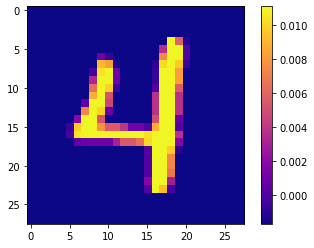

In [7]:
pixels = x_train_batches[0][0].reshape(28, 28).cpu()
print(pixels.shape)
plt.imshow(pixels, cmap = 'plasma')
plt.colorbar()
print(y_train_batches[0][0].cpu().numpy())

In [8]:
def relu(x):
    # a = torch.clamp(x, 0, 1).to(device)
    torch.nn.functional.relu(x, inplace = True).to(device)
    return x.double()

def del_relu(x):
    a = torch.nn.functional.relu(x, inplace = False).to(device)
    slope = (x == a).double()
    return slope

In [9]:
a = -1*torch.ones((20, 500)).to(device)
del_relu(a)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [10]:
t = torch.zeros(MINI_BATCH_SIZE, hlayer1.shape[1]).to(device)
print(t.shape)
# hard_sigmoid(t).shape

# x = torch.tensor([1])
print(del_relu(t).shape)

torch.Size([20, 1024])
torch.Size([20, 1024])


In [11]:
y_train_batches[0].shape

torch.Size([20, 10])

In [12]:
a = torch.tensor([[1, 2, 1],
                  [1, 2, 1]]).double()
b = torch.tensor([[1, 2, 1],
                  [1, 1, 1]]).double()
torch.sum(a * b, dim = 1).mean()

tensor(5., dtype=torch.float64)

In [13]:
# MINI NN
mbatch = 2
mW_xh1 = torch.ones(4, 2).double().to(device)

mW_h1y = torch.ones(2, 4).double().to(device)

mB_h1 = torch.ones(4).double().to(device) * 0.25

mB_y = torch.ones(2).double().to(device) * 0.2

minput_layer = torch.ones(mbatch, 2).double().to(device) * 0.5

mhlayer1 = torch.ones(mbatch, 4).double().to(device)

moutput_layer = torch.ones(mbatch, 2).double().to(device) * 0.5

my_hat = torch.zeros(mbatch, 2).double().to(device)
my_hat[0][0] = 1
my_hat[1][1] = 1

In [14]:
# print(mW_h1y) # N_op * N_curr
# print(moutput_layer) # batch * N_op
# print(mB_h1)
# print(mB_h1.repeat(mbatch, 1).shape)
print(mhlayer1)
# print(minput_layer)
# print((my_hat - moutput_layer)* 0.75)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)


In [15]:
torch.mean(mhlayer1, dim = 0)

tensor([1., 1., 1., 1.], device='cuda:0', dtype=torch.float64)

In [16]:
torch.mm(relu(mhlayer1.t()), relu(minput_layer)) / mbatch

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0', dtype=torch.float64)

In [17]:
a = torch.tensor([[1, 2, 3, 4],
                  [1, 1, 3, 3]]).double()
b = torch.tensor([[1],
                  [-1],
                  [2],
                  [-2]])
# print(a.shape, b.shape)
# a * b.t()
torch.mean(a, dim = 0)

tensor([1.0000, 1.5000, 3.0000, 3.5000], dtype=torch.float64)

In [18]:
(torch.mm(relu(minput_layer), mW_xh1.t()) + mB_h1.repeat(mbatch, 1)) * del_relu(mhlayer1)

tensor([[1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500, 1.2500]], device='cuda:0',
       dtype=torch.float64)

In [19]:
torch.mm(relu(moutput_layer), mW_h1y).shape # batch * curr

torch.Size([2, 4])

In [20]:
mhlayer1.shape

torch.Size([2, 4])

In [21]:
def ds_dt(W_prev, layer_prev, W_next, layer_next, N_layer, layer, B, y_hat, is_op, beta, m_batch = MINI_BATCH_SIZE):

    dc_ds = torch.zeros(m_batch, N_layer).to(device) # layer at a time

    de_ds = (torch.mm(relu(layer_prev), W_prev.t()) + B.repeat(m_batch, 1)).to(device)

    if is_op == 1:
        dc_ds = beta * (y_hat - layer)
    else:
        de_ds += torch.mm(relu(layer_next), W_next)

    de_ds *= del_relu(layer)
    de_ds -= layer

    return de_ds + dc_ds


In [22]:
# ds_dt(mW_xh1, minput_layer, mW_h1y, moutput_layer, mhlayer1.shape[1], mhlayer1, mB_h1, my_hat, 0, BETA, mbatch)
# ds_dt(mW_h1y, mhlayer1, None, None, moutput_layer.shape[1], moutput_layer, mB_y, my_hat, 1, BETA, mbatch)

In [23]:
# print(np.max(x_train[100]))
print(x_train_batches.shape)
print(y_train_batches.shape)
print(x_test_batches.shape)
print(y_test_batches.shape)
print(len(x_train_batches))
# print(x_train[4])

torch.Size([3000, 20, 784])
torch.Size([3000, 20, 10])
torch.Size([500, 20, 784])
torch.Size([500, 20, 10])
3000


In [24]:
dw_xh1 = torch.zeros(W_xh1.shape).to(device)
# dw_h1h2 = torch.zeros(W_h1h2.shape).to(device)
dw_h1y = torch.zeros(W_h1y.shape).to(device)

db_h1 = torch.zeros(B_h1.shape).to(device)
# db_h2 = torch.zeros(B_h2.shape).to(device)
db_y = torch.zeros(B_y.shape).to(device)

db_h1.shape

torch.Size([1024])

In [25]:
# SANITY CHECK
print(x_train_batches.device)
print(W_xh1.device)
print(hlayer1.device)
print(dw_xh1.device)

cuda:0
cuda:0
cuda:0
cuda:0


In [26]:
# output_layer = copy.deepcopy(y_train_batches[13])
# print(y_train_batches[13][11].argmax())
# output_layer[11] = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# output_layer[12] = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print(output_layer[11].argmax())
# c = 0
# for idx, element in enumerate(y_train_batches[13]):
#     c += int((element.argmax() == output_layer[idx].argmax()))
# print(c)

In [27]:
from tqdm.notebook import tqdm
import time
import random

total_iterations = len(x_train_batches)

In [28]:
torch.backends.cudnn.benchmark = True

In [29]:
# (torch.mm(torch.mm(hlayer1,W_xh1),input_layer.t()) * (torch.eye(MINI_BATCH_SIZE)).double().to(device)).shape
(torch.mm(torch.mm(hlayer1,W_xh1),input_layer.t()) * (torch.eye(MINI_BATCH_SIZE)).double().to(device)).mean() * 20

tensor(0., device='cuda:0', dtype=torch.float64)

In [30]:
def total_energy():
    t1 = ((torch.sum(input_layer * input_layer, dim = 1)).mean() + (torch.sum(hlayer1 * hlayer1, dim = 1)).mean() + (torch.sum(output_layer * output_layer, dim = 1)).mean()) * 0.5
    t2 = (torch.mm(torch.mm(relu(hlayer1),W_xh1),relu(input_layer).t()) * (torch.eye(MINI_BATCH_SIZE)).double().to(device)).mean() * MINI_BATCH_SIZE + (torch.mm(torch.mm(relu(output_layer),W_h1y),relu(hlayer1).t()) * (torch.eye(MINI_BATCH_SIZE)).double().to(device)).mean() * MINI_BATCH_SIZE
    t3 = torch.sum(B_h1 * relu(hlayer1), dim=1).mean() + torch.sum(B_y * relu(output_layer), dim=1).mean()

    print("Total Energy: ", t1 - t2 - t3)

In [31]:
start_total = time.time()

for epoch in range(EPOCHS):
    avg_time = 0

    # Training

    print("Currently running epoch ", epoch)

    for batch_index, batch in enumerate(x_train_batches):
        start = time.time()

        # Forward Pass

        input_layer = batch

        hlayer1.zero_()
        output_layer.zero_()

        dw_xh1.zero_()
        dw_h1y.zero_()

        db_h1.zero_()
        db_y.zero_()

        for iter in range(n_iter1):
            hlayer1 += epsilon * ds_dt(W_xh1, input_layer, W_h1y, output_layer, hlayer1.shape[1], hlayer1, B_h1, None, 0, 0)
            # hlayer1 = torch.clamp(hlayer1, 0, 1).double()

            output_layer += epsilon * ds_dt(W_h1y, hlayer1, None, None, output_layer.shape[1], output_layer, B_y, y_train_batches[batch_index], 1, 0)
            # output_layer = torch.clamp(output_layer, 0, 1).double()

        # Collect activations
        dw_xh1 -= torch.mm(relu(hlayer1.t()), relu(input_layer)) # mean across batches not done

        dw_h1y -= torch.mm(relu(output_layer.t()), relu(hlayer1))

        db_y -= torch.mean(output_layer, dim = 0) # mean across batches done

        db_h1 -= torch.mean(hlayer1, dim = 0)

        # Backward Pass
        for iter in range(n_iter2):

            hlayer1 += epsilon * ds_dt(W_xh1, input_layer, W_h1y, output_layer, hlayer1.shape[1], hlayer1, B_h1, None, 0, BETA)
            # hlayer1 = torch.clamp(hlayer1, 0, 1).double()

            output_layer += epsilon * ds_dt(W_h1y, hlayer1, None, None, output_layer.shape[1], output_layer, B_y, y_train_batches[batch_index], 1, BETA)
            # output_layer = torch.clamp(output_layer, 0, 1).double()

        # Collect activations

        dw_xh1 += torch.mm(relu(hlayer1.t()), relu(input_layer)) # mean across batches not done

        dw_h1y += torch.mm(relu(output_layer.t()), relu(hlayer1))

        db_y += torch.mean(output_layer, dim = 0) # mean across batches done

        db_h1 += torch.mean(hlayer1, dim = 0)

        # Update weights only after each minibatch

        W_h1y += a_h1y * (dw_h1y / (MINI_BATCH_SIZE * BETA))

        W_xh1 += a_xh1 * (dw_xh1 / (MINI_BATCH_SIZE * BETA))

        B_y += a_h1y * (db_y / BETA)

        B_h1 += a_xh1 * (db_h1 / BETA)

        end = time.time()

        avg_time += ((end - start - avg_time) / (batch_index + 1))

    print("Average training time per batch in epoch ", epoch, " = ", avg_time)

    total_energy()

    print("Testing model on training data")

    # TRAINING ERROR

    c = 0
    for test_index, test_batch_y in enumerate(y_test_batches):
        # Forward Pass

        input_layer = x_test_batches[test_index]

        hlayer1.zero_()
        output_layer.zero_()

        for iter in range(n_iter1):
            hlayer1 += epsilon * ds_dt(W_xh1, input_layer, W_h1y, output_layer, hlayer1.shape[1], hlayer1, B_h1, None, 0, 0)

            output_layer += epsilon * ds_dt(W_h1y, hlayer1, None, None, output_layer.shape[1], output_layer, B_y, test_batch_y, 1, 0)

        for idx, element in enumerate(test_batch_y):
            c += int((element.argmax() == output_layer[idx].argmax()))

    print("Correct ", c)
    acc = c / (MINI_BATCH_SIZE * len(y_test_batches))
    print("Testing accuracy after epoch ", epoch, " = ", acc*100)


total_time = time.time() - start_total
print("Total Time ",total_time)




Currently running epoch  0
Average training time per batch in epoch  0  =  0.08759772157669071
Total Energy:  tensor(-0.1495, device='cuda:0', dtype=torch.float64)
Testing model on training data
Correct  6794
Testing accuracy after epoch  0  =  67.94
Currently running epoch  1
Average training time per batch in epoch  1  =  0.08768931770324698
Total Energy:  tensor(-0.2196, device='cuda:0', dtype=torch.float64)
Testing model on training data
Correct  7341
Testing accuracy after epoch  1  =  73.41
Currently running epoch  2
Average training time per batch in epoch  2  =  0.08759915908177693
Total Energy:  tensor(-0.2820, device='cuda:0', dtype=torch.float64)
Testing model on training data
Correct  7838
Testing accuracy after epoch  2  =  78.38000000000001
Currently running epoch  3
Average training time per batch in epoch  3  =  0.08776877180735272
Total Energy:  tensor(-0.3231, device='cuda:0', dtype=torch.float64)
Testing model on training data
Correct  8455
Testing accuracy after epo

KeyboardInterrupt: 